Cleaning Data

In this notebook we start the analizing the dataset and correct errors

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import  Path

In [ ]:
df = pd.read_csv(Path("data/Chicago_Taxi_Trips_2020_10percent.csv")) # this open the csv dataset considering the path
#print(df.head()) #first 5 lines

df.columns = [c.replace(' ', '_') for c in df.columns]  #replaces spaces in columns with underscores

In [2]:
df.shape

(342292, 23)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342292 entries, 0 to 342291
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Trip_ID                     342292 non-null  object 
 1   Taxi_ID                     342274 non-null  object 
 2   Trip_Start_Timestamp        342292 non-null  object 
 3   Trip_End_Timestamp          342238 non-null  object 
 4   Trip_Seconds                342158 non-null  float64
 5   Trip_Miles                  342291 non-null  float64
 6   Pickup_Census_Tract         174085 non-null  float64
 7   Dropoff_Census_Tract        172971 non-null  float64
 8   Pickup_Community_Area       318310 non-null  float64
 9   Dropoff_Community_Area      310733 non-null  float64
 10  Fare                        342258 non-null  float64
 11  Tips                        342258 non-null  float64
 12  Tolls                       342258 non-null  float64
 13  Extras        

In [4]:
df.head()

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,Extras,Trip_Total,Payment_Type,Company,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Pickup_Centroid_Location,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,Dropoff_Centroid__Location
0,7fa9327d2a62e0f1f9eac0f5a4ca0bb5338c22b2,03906d62f91d139ab93f74f50d1b208805b7fbb61e8d1e...,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,178.0,0.48,1.703132e+10,1.703132e+10,32.0,32.0,...,3.0,10.00,Credit Card,Flash Cab,41.877406,-87.621972,POINT (-87.6219716519 41.8774061234),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918)
1,493354c5b05333aeeb05055a4914c5d38bacef60,ca885a78545e9a44a5f365164cfbaca32fee95082b0d4f...,01/01/2020 12:00:00 AM,01/01/2020 12:30:00 AM,1200.0,5.30,NaN,NaN,8.0,23.0,...,0.0,20.10,Credit Card,Star North Management LLC,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.900070,-87.720918,POINT (-87.7209182385 41.9000696026)
2,450f3aa6b31aa37cbb7c972f92a9ba31ab506c79,81bc2020b8536280419b3e152ad07a0c5b9f53cbb503a0...,01/01/2020 12:00:00 AM,01/01/2020 12:15:00 AM,540.0,1.70,1.703108e+10,1.703108e+10,8.0,8.0,...,0.0,8.00,Cash,Taxi Affiliation Services,41.907492,-87.635760,POINT (-87.6357600901 41.9074919303),41.892073,-87.628874,POINT (-87.6288741572 41.8920726347)
3,39100cdb94f6da6b54f71f1d1cdc2ba330f97e09,a548c63608ec50e02a2311a0b6b1b2274995e3637ccb4c...,01/01/2020 12:00:00 AM,01/01/2020 12:15:00 AM,419.0,0.98,1.703128e+10,1.703184e+10,28.0,32.0,...,1.0,7.50,Cash,City Service,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707)
4,36bbb8cf2622b3ce7dde8f6bbaacc903a8403333,33164e16dd29b1c58cd15cce31df4bfcb75d9903cb66de...,01/01/2020 12:00:00 AM,01/01/2020 12:30:00 AM,1800.0,1.50,1.703128e+10,1.703132e+10,28.0,32.0,...,1.0,15.25,Cash,Medallion Leasin,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918)


### Preparazione dati

In [5]:
df.isnull().tail()  #vede se nelle ultime 5 righe esitono valori NaN. L'ho usato solo per capire come funziona la funzione

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,Extras,Trip_Total,Payment_Type,Company,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Pickup_Centroid_Location,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,Dropoff_Centroid__Location
342287,False,False,False,False,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
342288,False,False,False,False,False,False,True,True,True,True,...,False,False,False,False,True,True,True,True,True,True
342289,False,False,False,False,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
342290,False,False,False,False,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
342291,False,False,False,False,False,False,True,True,False,True,...,False,False,False,False,False,False,False,True,True,True


In [6]:
df.Pickup_Census_Tract[342288]  #le celle che appaiono vuote sono effettivamente NaN...

nan

In [7]:
#trovo missing values con Pandas, per tutte le colonne
df.isnull().sum() #conta quanti NaN per ogni colonna

Trip_ID                            0
Taxi_ID                           18
Trip_Start_Timestamp               0
Trip_End_Timestamp                54
Trip_Seconds                     134
Trip_Miles                         1
Pickup_Census_Tract           168207
Dropoff_Census_Tract          169321
Pickup_Community_Area          23982
Dropoff_Community_Area         31559
Fare                              34
Tips                              34
Tolls                             34
Extras                            34
Trip_Total                        34
Payment_Type                       0
Company                            0
Pickup_Centroid_Latitude       23930
Pickup_Centroid_Longitude      23930
Pickup_Centroid_Location       23930
Dropoff_Centroid_Latitude      30916
Dropoff_Centroid_Longitude     30916
Dropoff_Centroid__Location     30916
dtype: int64

In [8]:
#altro modo per trovare missing values con numpy
MV = np.isnan(df.Fare)  #ritorna colonna di True/False, ma è da ripetere per ogni colonna

unique, counts = np.unique(MV, return_counts=True)
unique, counts

(array([False,  True]), array([342258,     34], dtype=int64))

In [9]:
# elimino righe dove mancano TUTTI i valori --> uso: how='all'
# --> risulta che tutte le righe hanno almeno un valore valido
df.dropna(how='all').shape

(342292, 23)

### Statistiche

In [10]:
from scipy.stats import median_abs_deviation #as median_abs_deviation

In [11]:
def statistics(variable):
    stats = {}
    stats['mean'] = variable.mean()
    stats['std'] = variable.std()
    stats['max'] = variable.max()
    stats['min'] = variable.min()
    stats['median'] = np.nanmedian(variable)  #NANmedian invece di median
    stats['10%'] = np.nanpercentile(variable,10)  #NANpercentile invece di percentile
    stats['25%'] = np.nanpercentile(variable,25)  #NANpercentile invece di percentile
    stats['75%'] = np.nanpercentile(variable,75)  #NANpercentile invece di percentile
    stats['99%'] = np.nanpercentile(variable,99)  #NANpercentile invece di percentile
    stats['99.9%'] = np.nanpercentile(variable,99.9)  #NANpercentile invece di percentile
    stats['mad'] = median_abs_deviation(variable, nan_policy = 'omit')
    return stats


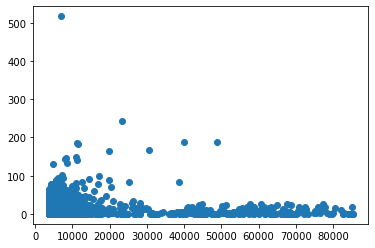

In [12]:
pippo = df[df.Trip_Seconds > 3600]
plt.scatter(pippo.Trip_Seconds, pippo.Trip_Miles)
plt.show()

Iniziamo ad analizzare i dati dei viaggi:

E

In [13]:
statistics(df.Trip_Seconds)

{'mean': 849.9995382250305,
 'std': 1687.5361388391007,
 'max': 85320.0,
 'min': 0.0,
 'median': 560.0,
 '10%': 180.0,
 '25%': 346.0,
 '75%': 1020.0,
 '99%': 3600.0,
 '99.9%': 13835.686000000103,
 'mad': 280.0}

In [14]:
statistics(df.Trip_Miles)

{'mean': 3.559530662506332,
 'std': 6.55107950073385,
 'max': 980.5,
 'min': 0.0,
 'median': 1.21,
 '10%': 0.0,
 '25%': 0.5,
 '75%': 3.55,
 '99%': 21.2,
 '99.9%': 37.72,
 'mad': 1.1099999999999999}

In [15]:
statistics(df.Fare)

{'mean': 15.1731601306616,
 'std': 79.14001556006875,
 'max': 9004.25,
 'min': 0.0,
 'median': 8.25,
 '10%': 4.75,
 '25%': 6.0,
 '75%': 16.0,
 '99%': 57.5,
 '99.9%': 117.68575000000419,
 'mad': 3.0}

In [16]:
statistics(df.Tips)

{'mean': 1.54961987740238,
 'std': 2.9250925867900017,
 'max': 300.0,
 'min': 0.0,
 'median': 0.0,
 '10%': 0.0,
 '25%': 0.0,
 '75%': 2.0,
 '99%': 11.94,
 '99.9%': 20.0,
 'mad': 0.0}

In [17]:
statistics(df.Tolls)

{'mean': 0.0016755780726820102,
 'std': 0.12916501531482125,
 'max': 50.0,
 'min': 0.0,
 'median': 0.0,
 '10%': 0.0,
 '25%': 0.0,
 '75%': 0.0,
 '99%': 0.0,
 '99.9%': 0.0,
 'mad': 0.0}

In [18]:
statistics(df.Extras)

{'mean': 1.124313763301369,
 'std': 27.528929704306677,
 'max': 9900.66,
 'min': 0.0,
 'median': 0.0,
 '10%': 0.0,
 '25%': 0.0,
 '75%': 1.0,
 '99%': 17.0,
 '99.9%': 48.5,
 'mad': 0.0}

In [19]:
statistics(df.Trip_Total)

{'mean': 17.96355334279932,
 'std': 84.32197375051707,
 'max': 9903.91,
 'min': 0.0,
 'median': 9.78,
 '10%': 5.25,
 '25%': 7.0,
 '75%': 18.25,
 '99%': 74.2,
 '99.9%': 155.14860000000334,
 'mad': 3.7799999999999994}

In [20]:
#solo colonne su cui ha senso fare media, mediana, ecc...
#num_features = [4,5,10,11,12,13,14]
#num_features = ['Trip_Seconds','Trip_Miles','Fare','Tips','Tolls','Extras','Trip_Total']

In [21]:
#def summarize(data, features):
    #summary = {}
    #for i in range(6):
        #summary[i] = statistics(data.iloc[:,features[i]])
    #return summary

In [22]:
#summarize(df,num_features)

### Distance Travelled

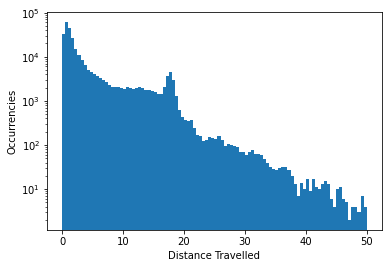

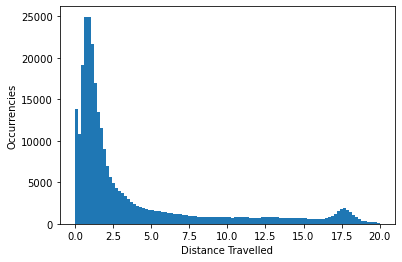

In [23]:
#limito il range nel grafico o direttamente elimino i dati sopra il 99 percentile dal database

plt.hist(df.Trip_Miles, bins = 100, range = (0.01, 50))
plt.yscale('log')   #scala logaritmica
plt.xlabel('Distance Travelled')
plt.ylabel('Occurrencies')
plt.show()

plt.hist(df.Trip_Miles, bins = 100, range = (0.01, 20))
plt.xlabel('Distance Travelled')
plt.ylabel('Occurrencies')
plt.show()

#### Investigo perchè ci sono tanti viaggi di 17.5 miglia

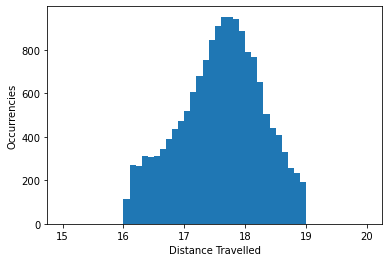

In [24]:
#isolo i viaggi tra 16 e 19 miglia
trips = df[(df.Trip_Miles > 16) & (df.Trip_Miles < 19)]

plt.hist(trips.Trip_Miles, bins = 50, range = (15, 20))
plt.xlabel('Distance Travelled')
plt.ylabel('Occurrencies')
plt.show()

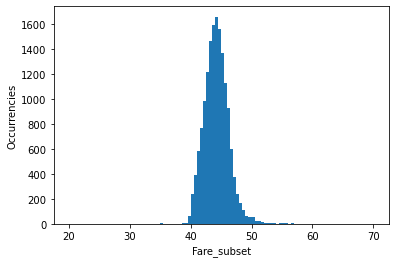

In [25]:
#visualizzo prezzo dei viaggi tra 16 e 19 miglia
plt.hist(trips.Fare, bins = 100, range = (20, 70))
plt.xlabel('Fare_subset')
plt.ylabel('Occurrencies')
plt.show()

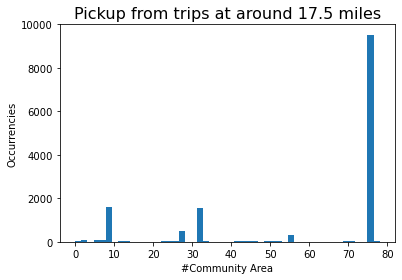

In [26]:
# molti viaggi tra 16 e 19 miglia partono da Community_Area 76 - O'Hare Airport
plt.hist(trips.Pickup_Community_Area, bins = 50, range = (0, 78))
plt.xlabel('#Community Area')
plt.ylabel('Occurrencies')
plt.title('Pickup from trips at around 17.5 miles', fontsize = 16)
plt.show()

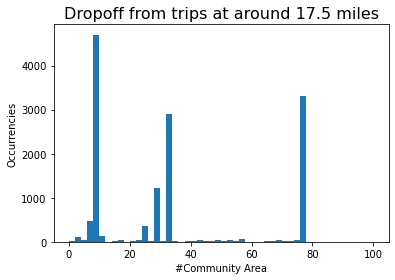

In [27]:
# molti viaggi tra 16 e 19 miglia vanno a Community_Area 8,24,28,32,76
# 8: Near North Side - 24: West Town - 28: Near West Side - 32: Loop
plt.hist(trips.Dropoff_Community_Area, bins = 50, range = (0, 100))
plt.xlabel('#Community Area')
plt.ylabel('Occurrencies')
plt.title('Dropoff from trips at around 17.5 miles', fontsize = 16)
plt.show()

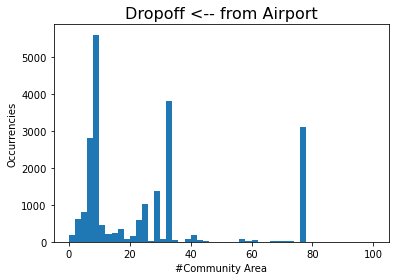

In [28]:
#isolo SOLO i viaggi che partono da Community Area 76 (aeroporto)
from_76 = df[df.Pickup_Community_Area == 76]
#plotto dove va la gente che parte dall'aeroporto
plt.hist(from_76.Dropoff_Community_Area, bins = 50, range = (0, 100))
plt.xlabel('#Community Area')
plt.ylabel('Occurrencies')
plt.title('Dropoff <-- from Airport', fontsize = 16)
plt.show()

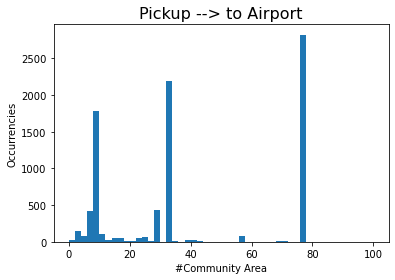

In [29]:
#isolo SOLO i viaggi che arrivano a Community Area 76 (aeroporto)
to_76 = df[df.Dropoff_Community_Area == 76]
#plotto da dove parte la gente che arriva all'aeroporto
plt.hist(to_76.Pickup_Community_Area, bins = 50, range = (0, 100))
plt.xlabel('#Community Area')
plt.ylabel('Occurrencies')
plt.title('Pickup --> to Airport', fontsize = 16)
plt.show()

### Pickup/Dropoff delle Community Areas

#### In istogramma

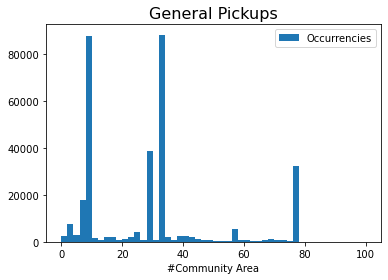

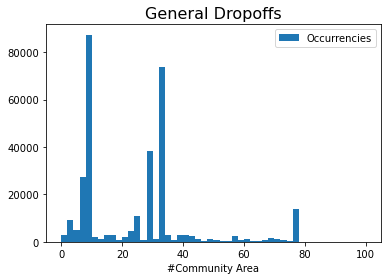

In [30]:
plt.hist(df.Pickup_Community_Area, bins = 50, range = (0, 100), label='Occurrencies')
plt.xlabel('#Community Area')
plt.title('General Pickups', fontsize = 16)
plt.legend()
plt.show()

plt.hist(df.Dropoff_Community_Area, bins = 50, range = (0, 100), label='Occurrencies')
plt.xlabel('#Community Area')
plt.title('General Dropoffs', fontsize = 16)
plt.legend()
plt.show()

#### In coordinate geografiche

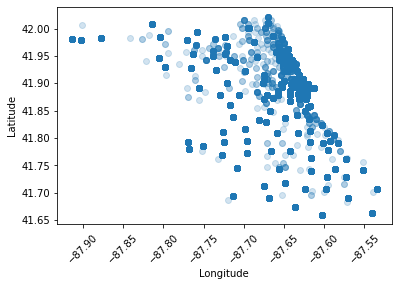

<Figure size 800x800 with 0 Axes>

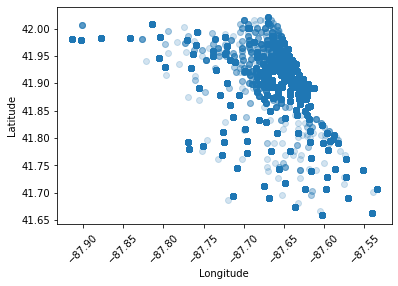

In [31]:
#Partenza
plt.scatter(df.Pickup_Centroid_Longitude, df.Pickup_Centroid_Latitude, alpha=0.2)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xticks(rotation=45)
plt.figure(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.show()
#Arrivo
plt.scatter(df.Dropoff_Centroid_Longitude, df.Dropoff_Centroid_Latitude, alpha=0.2)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xticks(rotation=45)
plt.show()

### Trip Duration

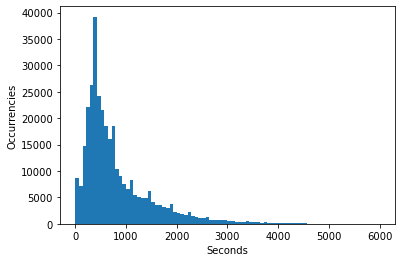

In [32]:
plt.hist(df.Trip_Seconds, bins = 84, range = (1, 6000))
#plt.yscale('log')
plt.xlabel('Seconds')
plt.ylabel('Occurrencies')
plt.show()

### Fares and Extras

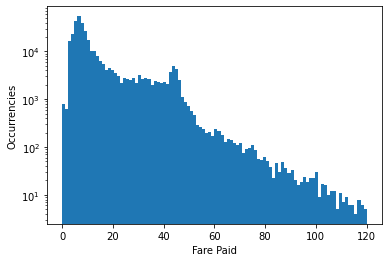

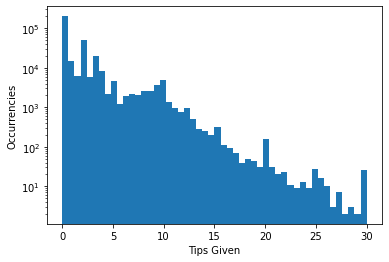

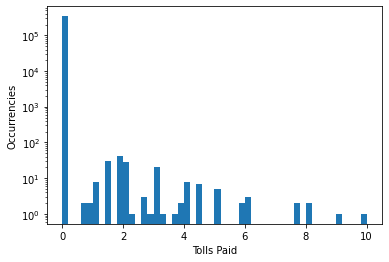

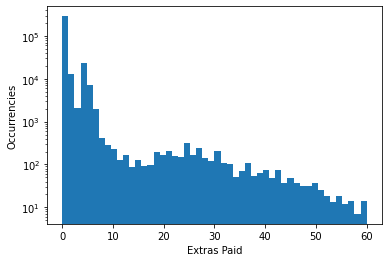

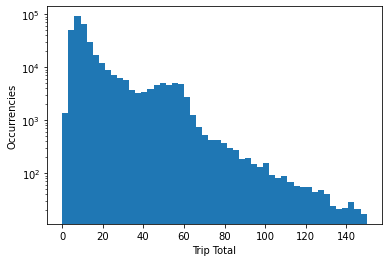

In [33]:
#scala logaritmica

plt.hist(df.Fare, bins = 100, range = (0, 120))
plt.yscale('log')
plt.xlabel('Fare Paid')
plt.ylabel('Occurrencies')
plt.show()

plt.hist(df.Tips, bins = 50, range = (0, 30))
plt.yscale('log')
plt.xlabel('Tips Given')
plt.ylabel('Occurrencies')
plt.show()

plt.hist(df.Tolls, bins = 50, range = (0, 10))
plt.yscale('log')
plt.xlabel('Tolls Paid')
plt.ylabel('Occurrencies')
plt.show()

plt.hist(df.Extras, bins = 50, range = (0, 60))
plt.yscale('log')
plt.xlabel('Extras Paid')
plt.ylabel('Occurrencies')
plt.show()

plt.hist(df.Trip_Total, bins = 50, range = (0, 150))
plt.yscale('log')
plt.xlabel('Trip Total')
plt.ylabel('Occurrencies')
plt.show()

### Payment Method

In [34]:
df.Payment_Type.value_counts()

Cash           167050
Credit Card    142367
Prcard          14912
Unknown         11183
Mobile           6110
No Charge         456
Dispute           193
Prepaid            21
Name: Payment_Type, dtype: int64

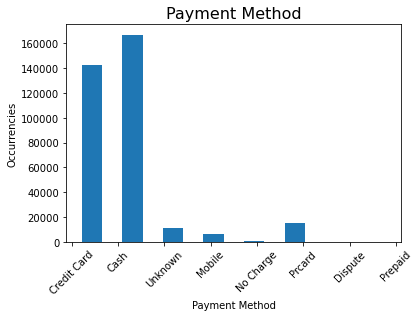

In [35]:
plt.hist(df.Payment_Type, bins = 8, rwidth=0.5)
plt.xlabel('Payment Method')
plt.ylabel('Occurrencies')
plt.title('Payment Method', fontsize = 16)
plt.xticks(rotation=45)
plt.show()

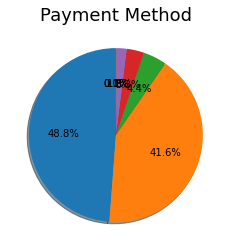

In [36]:
plt.pie(df.Payment_Type.value_counts(), shadow=True, autopct='%1.1f%%', startangle=90)
plt.title('Payment Method', fontsize=18)
#plt.legend()
plt.show()

### Timestamps (formato americano: mese-gg-anno)

In [37]:
df.Trip_Start_Timestamp = pd.to_datetime(df.Trip_Start_Timestamp)
df.Trip_Start_Timestamp

0        2020-01-01 00:00:00
1        2020-01-01 00:00:00
2        2020-01-01 00:00:00
3        2020-01-01 00:00:00
4        2020-01-01 00:00:00
                 ...        
342287   2020-09-30 23:30:00
342288   2020-09-30 23:30:00
342289   2020-09-30 23:45:00
342290   2020-09-30 23:45:00
342291   2020-10-01 00:00:00
Name: Trip_Start_Timestamp, Length: 342292, dtype: datetime64[ns]

In [38]:
df.Trip_Start_Timestamp.min()

Timestamp('2020-01-01 00:00:00')

In [39]:
df.Trip_Start_Timestamp.max()

Timestamp('2020-10-01 00:00:00')

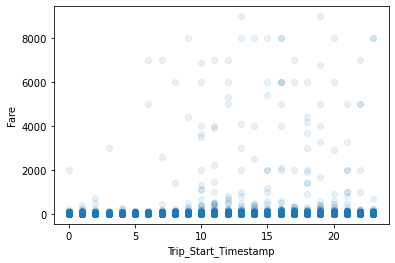

In [40]:
plt.scatter(df.Trip_Start_Timestamp.dt.hour, df.Fare, alpha = 0.1)
plt.xlabel('Trip_Start_Timestamp')
plt.ylabel('Fare')
plt.show()

### Companies

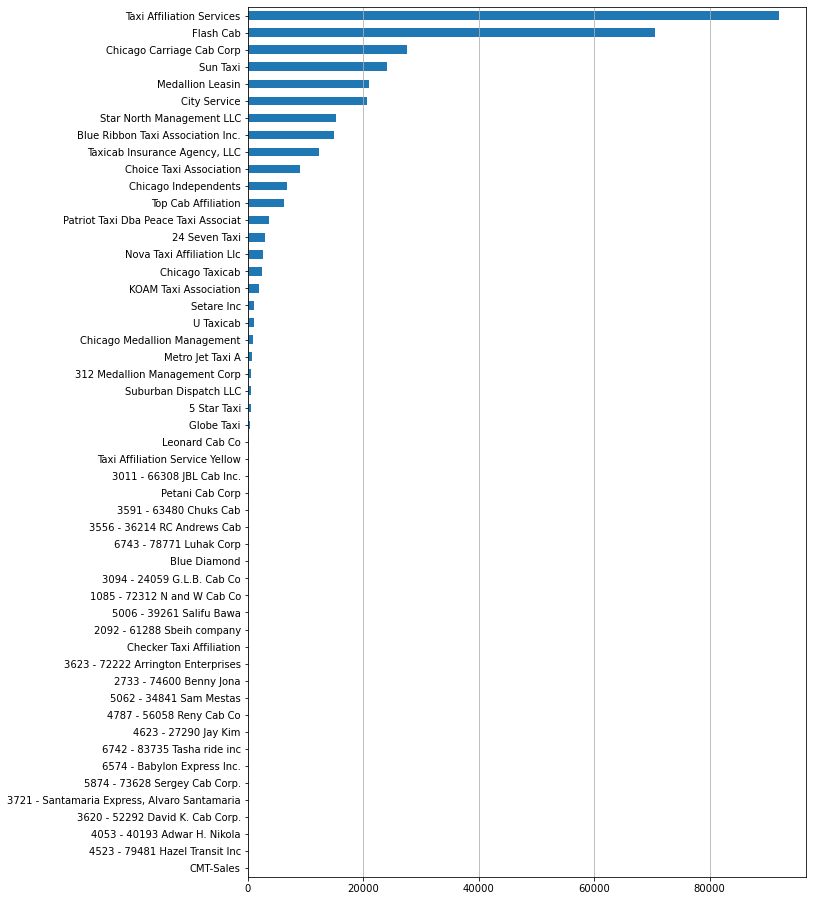

In [41]:
df.Company.value_counts().sort_values(ascending=True).plot(kind='barh', figsize=(10,16), fontsize=10)
plt.grid(b=None, which='major', axis='x')

#### Trovo costo medio per ogni compagnia

In [42]:
#calcola prezzo per minuto (ppm)
def performance(feature, numerator, denominator, method):
    features_labels = df.feature.unique()  #segna in un array tutti i nomi della categoria
    for i in range(len(features_labels)):  #per ogni nome...
        subset = df[feature == features_labels[i]]
        num = subset.numerator.method()
        den = subset.denominator.method()  #trip duration in minutes
        perf = num/den
    return perf  

In [43]:
performance(Company, Trip_Total, Trip_Seconds, median) #TODO togliere funzionne

NameError: name 'Company' is not defined

### Provo in modo grezzo a filtrare i dati e a plottarli

#### TripMiles vs. Fare

### Linea sospetta (c)

In [ ]:
#Isolo la linea piccolina (non la principale)
a = df[(df.Trip_Miles < 6) & (df.Trip_Miles > 0)]
b = a[(a.Fare < 300) & (a.Fare > 20)]
c = b[((b.Trip_Miles < 1.7) | (b.Fare > 60)) & ((b.Trip_Miles < 1) | (b.Fare > 35))]  #linea "sospetta" isolata

In [ ]:
plt.scatter(c.Trip_Miles, c.Fare, alpha = 0.1)
plt.xlabel('Trip Miles')
plt.ylabel('Fare')
plt.show()

In [ ]:
plt.scatter(c.Pickup_Centroid_Longitude, c.Fare, alpha = 0.1)
plt.xlabel('Trip Miles')
plt.ylabel('Fare')
plt.show()

#### Duration vs. Fare

In [ ]:
#TODO
e = d[d.Trip_Seconds < 15000]
f = e[e.Trip_Seconds > 0]

plt.scatter(f.Trip_Seconds, f.Fare, alpha = 0.1)
plt.xlabel('Trip Seconds')
plt.ylabel('Fare')
plt.show()

#### TimeStart vs. Fare

In [ ]:
plt.scatter(c.Trip_Start_Timestamp.dt.hour, c.Fare, alpha = 0.1)
plt.xlabel('Trip_Start_Timestamp')
plt.ylabel('Fare')
plt.show()

In [ ]:
subset = np.isnan(df.Fare)  #controlla quanti NaN ci sono
unique, counts = np.unique(subset, return_counts=True)
unique, counts  #ritorna il numero di occorrenze